In [ ]:
%pip install elephant quantities neo pathlib numpy xarray matplotlib scipy pyocclient netCDF4

### Utility functions

Run the cell below, but feel free to ignore this code — it’s just some utility functions we’ll use later for convenience.

In [1]:
import numpy as np
import neo
import quantities as pq
from elephant.current_source_density import estimate_csd

def add_um_units(channels_depth_vals):
    """Add units to coordinates of channels on probe"""
    return np.array([np.abs(channels_depth_vals)]).T*pq.um

def create_neo_lfp(lfp_values, sampling_frequency):
    """Put lfp data in time window in neo format"""
    return neo.AnalogSignal(lfp_values, units=pq.V, sampling_rate=sampling_frequency*pq.Hz)

class utils:
    add_um_units = add_um_units
    create_neo_lfp = create_neo_lfp

## Download dataset

In [23]:
import owncloud
import os

if not os.path.exists('../../data'):
    print('Creating directory for data')
    os.mkdir('../../data')

if not os.path.exists('../../data/dataset_session_754312389.nc'):
    print('Downloading data')
    owncloud.Client.from_public_link('https://uni-bonn.sciebo.de/s/ZAs9uJ1KzrWi0ra').get_file('/', '../../data/dataset_session_754312389.nc')
else:
    print('Dataset already downloaded')

Dataset already downloaded


### Load dataset

Run cells below to load dataset and extract relevant data

In [2]:
import xarray as xr
from pathlib import Path

In [3]:
loadpath = '../../data/dataset_session_754312389.nc'

dataset_path = Path(loadpath)

dataset = xr.load_dataset(dataset_path)
dataset

<xarray.Dataset> Size: 232MB
Dimensions:                             (channel_depth: 23,
                                         trial_stimulus_id: 75,
                                         time_from_stimulus_onset_lfp: 1875,
                                         time_from_stimulus_onset_csd: 1875,
                                         time_whole_rec: 373124,
                                         channel_depth_LM: 19,
                                         ...
                                         time_from_stimulus_onset_spikes: 1500,
                                         unit_id_V1: 91, unit_id_LM: 13,
                                         stimulus_start_times: 75,
                                         stimulus_stop_times: 75,
                                         channel_id: 23,
                                         time_from_stimulus_onset_lfp_trial: 1875)
Coordinates: (12/17)
  * channel_depth                       (channel_depth) int64 184B 0 ... -880
  * trial_stimulus_id                   (trial_stimulus_id) int32 300B 3649 ....
  * time_from_stimulus_onset_lfp        (time_from_stimulus_onset_lfp) float64 15kB ...
  * time_from_stimulus_onset_csd        (time_from_stimulus_onset_csd) float64 15kB ...
  * time_whole_rec                      (time_whole_rec) float64 3MB 1.286e+0...
  * channel_depth_LM                    (channel_depth_LM) int64 152B 0 ... -720
    ...                                  ...
  * unit_id_V1                          (unit_id_V1) int32 364B 951795075 ......
  * unit_id_LM                          (unit_id_LM) int32 52B 951791074 ... ...
  * stimulus_start_times                (stimulus_start_times) float64 600B 1...
  * stimulus_stop_times                 (stimulus_stop_times) float64 600B 1....
  * channel_id                          (channel_id) int32 92B 850144538 ... ...
  * time_from_stimulus_onset_lfp_trial  (time_from_stimulus_onset_lfp_trial) float64 15kB ...
Data variables:
    lfp_trials                          (channel_depth, trial_stimulus_id, time_from_stimulus_onset_lfp) float64 26MB ...
    csd_trials                          (channel_depth, trial_stimulus_id, time_from_stimulus_onset_csd) float64 26MB ...
    lfp_whole_recording                 (channel_depth, time_whole_rec) float64 69MB ...
    ecp_whole_recording                 (channel_depth, time_whole_rec) float64 69MB ...
    lfp_LM                              (channel_depth_LM, trial_stimulus_id_LM, time_from_stimulus_onset_LM_lfp) float64 11MB ...
    spike_counts_LGN                    (unit_id_LGN, trial_nr, time_from_stimulus_onset_spikes) int16 6MB ...
    spike_counts_V1                     (unit_id_V1, trial_nr, time_from_stimulus_onset_spikes) int16 20MB ...
    spike_counts_LM                     (unit_id_LM, trial_nr, time_from_stimulus_onset_spikes) int16 3MB ...
    pupil_width                         (trial_nr) float64 600B 39.12 ... 44.31
    run_speed                           (trial_nr) float64 600B 1.155 ... 1.711
Attributes:
    time_unit:                  millisecond
    lfp_unit:                   Volt
    channel_depth_unit:         micrometer
    note_channel_depth:         Measured in distance from electrode closest t...
    sampling_frequency_lfp:     1250
    sampling_frequency_spikes:  1000
    sampling_frequency_unit:    Hz

#### Extract spike data

In [4]:
spike_counts_LGN = dataset['spike_counts_LGN']
spike_counts_V1 = dataset['spike_counts_V1']
spike_counts_LM = dataset['spike_counts_LM']

#### Extract LFP data

In [5]:
# extract data

lfp_trials = dataset['lfp_trials']
lfp_trial_avg = np.mean(lfp_trials, axis=1)
channels_depth = dataset['channel_depth']
sampling_frequency_lfp = dataset.sampling_frequency_lfp

# Introduction

LFP reflects currents caused by synaptic input. Spikes in a presynaptic population activates the synaptic currents in the postsynaptic population. Therefore, the LFP, and by extension the CSD, reflects the spikes in a presynaptic population. In this notebook, you will learn how to calculate and plot firing rates and combine firing rate analysis with CSD analysis to observe this relationship between spikes and LFP/CSD.

## Section 1

### Calculate and plot firing rates from spike data

| Code | Description |
| :-- | :-- |
| `np.arange(start, stop, step)` | Makes an array with all the integers between two values, with a given spacing |
| `np.mean(data, axis = (dim_num))` or `data.mean(axis = dim_num)` | Calculate the average of the data across the `dim_num` dimension of the array. |
| `np.mean(data, axis = (dim_num1, dim_num2))` or `data.mean(axis = (dim_num1, dim_num2)` | Calculate the average of the data across both the `dim_num1` and the `dim_num2` dimensions of the array. |
| `plt.plot(x, y)` | Plot y values against x values. |
| `second_row = data[1, :]` | Get data on second row in 2D data array. |
| `third_column = data[:, 2]` | Get data on third column in 2D data array. |
| `element_second_row_third_column = data[1, 2]` | Get the single element on second row and third column in 2D data array. |


In [6]:
from scipy.ndimage import gaussian_filter1d

import matplotlib.pyplot as plt


**Example**: Plot the spike count (also often called spike train) of the LGN cell at index 0 in trial index 2.

Text(0.5, 0, 'Time from stimulus onset (ms)')

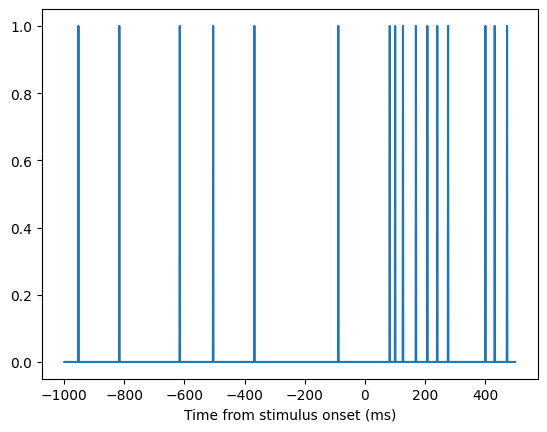

In [7]:
# solution

icell = 0
itrial = 2

time_from_stimulus_onset = spike_counts_LGN.time_from_stimulus_onset_spikes
plt.plot(time_from_stimulus_onset, spike_counts_LGN[icell, itrial])
plt.xlabel('Time from stimulus onset (ms)')

**Exercise**: Plot the spike count of a **V1** cell at index 0 in trial index 2.

Text(0.5, 0, 'Time from stimulus onset (ms)')

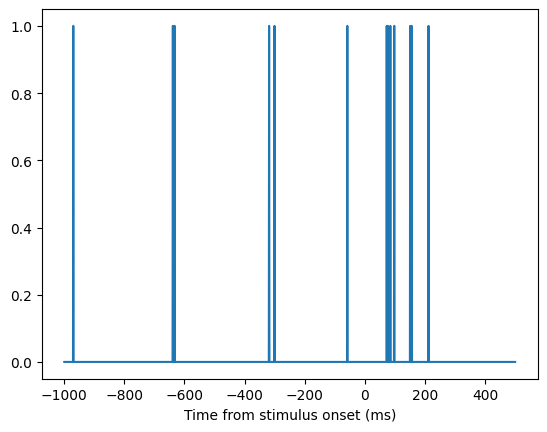

In [9]:
# solution
icell = 0
itrial = 2

time_from_stimulus_onset = spike_counts_V1.time_from_stimulus_onset_spikes
plt.plot(time_from_stimulus_onset, spike_counts_V1[icell, itrial])
plt.xlabel('Time from stimulus onset (ms)')

**Exercise**: Plot the spike count of an **LM** cell at index 6 in trial index 50.

Text(0.5, 0, 'Time from stimulus onset (ms)')

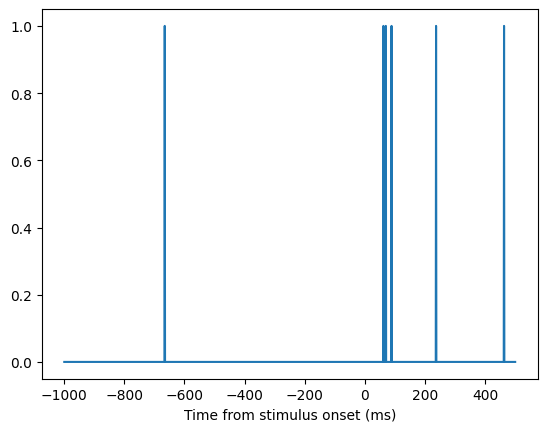

In [10]:
# solution
icell = 6
itrial = 50

time_from_stimulus_onset = spike_counts_LM.time_from_stimulus_onset_spikes
plt.plot(time_from_stimulus_onset, spike_counts_LM[icell, itrial])
plt.xlabel('Time from stimulus onset (ms)')

**Example**: Calculate the trial averaged firing rate of all LGN cells and plot the firing rate of cell nr. 0.

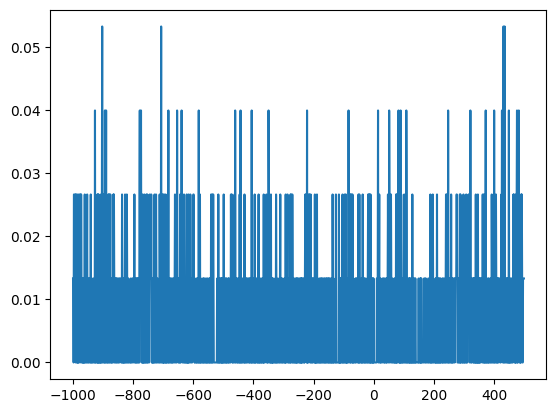

In [11]:
icell = 0

firing_rates_LGN = np.mean(spike_counts_LGN, axis=1)

plt.plot(time_from_stimulus_onset, firing_rates_LGN[icell])

**Exercise**: Calculate and plot the trial averaged firing rates of cell at index 10 in V1. 

Does this cell appear to be responding to the onset and offset of the stimulus? (Onset is at 0 ms and offset is at 250 ms.)

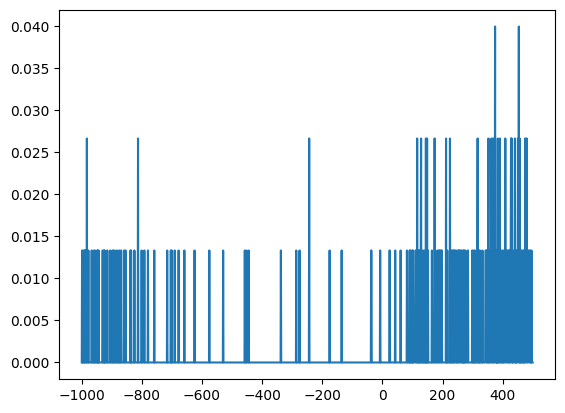

In [12]:
# solution
icell = 10

firing_rates_V1 = np.mean(spike_counts_V1, axis=1)

plt.plot(time_from_stimulus_onset, firing_rates_V1[icell])

**Exercise**: Calculate and plot the trial averaged firing rates for the cell at index 6 in LM.

Does this cell respond to stimulus onset or offset or both?

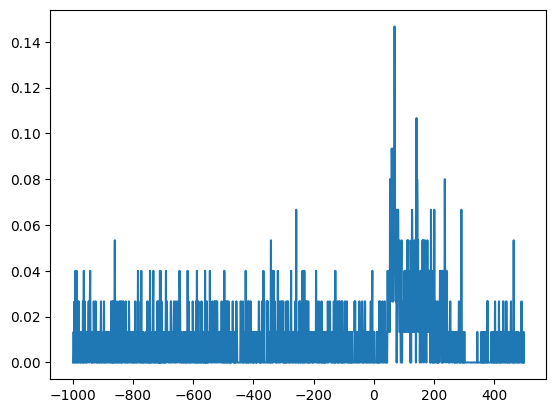

In [13]:
# solution
icell = 6

firing_rates_LM = np.mean(spike_counts_LM, axis=1)

plt.plot(time_from_stimulus_onset, firing_rates_LM[icell])

**Exercise**: Calculate and plot the **population** firing rates in trial 0 in LGN.

NB: The trials are on dimension/axis 1 in the spike counts array. The cells in the population are on dimension/axis 0.

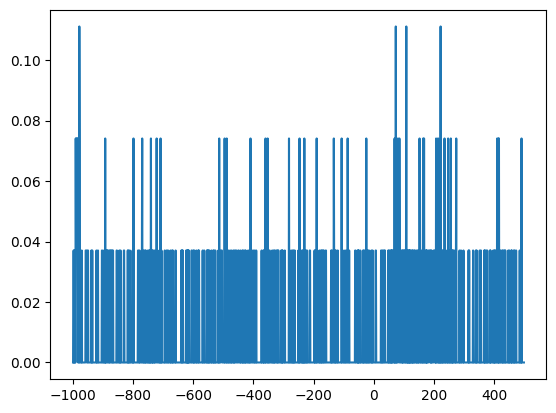

In [17]:
# solution
itrial = 0
pop_firing_rates_LGN = np.mean(spike_counts_LGN, axis=0)

plt.plot(time_from_stimulus_onset, pop_firing_rates_LGN[itrial])


**Exercise**: Calculate and plot the *population* firing rate in trial 0 in V1.

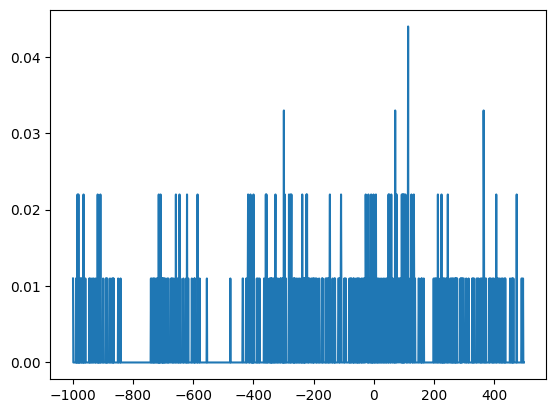

In [18]:
# solution
itrial = 0
pop_firing_rates_V1 = np.mean(spike_counts_V1, axis=0)

plt.plot(time_from_stimulus_onset, pop_firing_rates_V1[itrial])


**Example**: Calculate and plot **trial averaged population** firing rate in LGN.

Is the timing of the firing rate peaks occuring where you would expect?

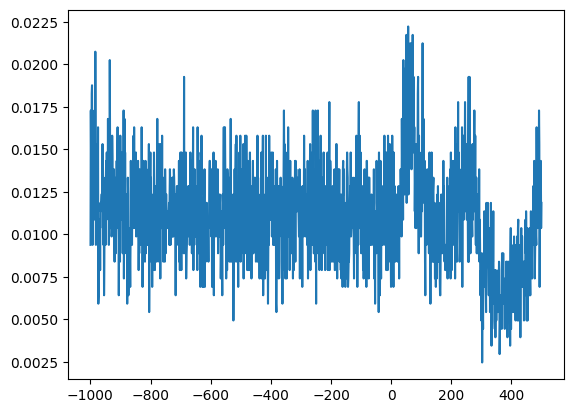

In [19]:
pop_firing_rate_LGN_trial_avg = np.mean(spike_counts_LGN, axis=(0,1))

plt.plot(time_from_stimulus_onset, pop_firing_rate_LGN_trial_avg)

**Exercise**: Calculate and plot *trial averaged population* firing rate in V1.

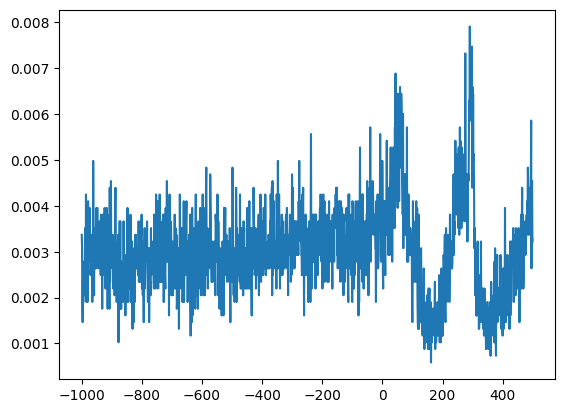

In [20]:
# solution
pop_firing_rate_V1_trial_avg = np.mean(spike_counts_V1, axis=(0,1))

plt.plot(time_from_stimulus_onset, pop_firing_rate_V1_trial_avg)

**Exercise**: Calculate and plot *trial averaged population* firing rate in LM.

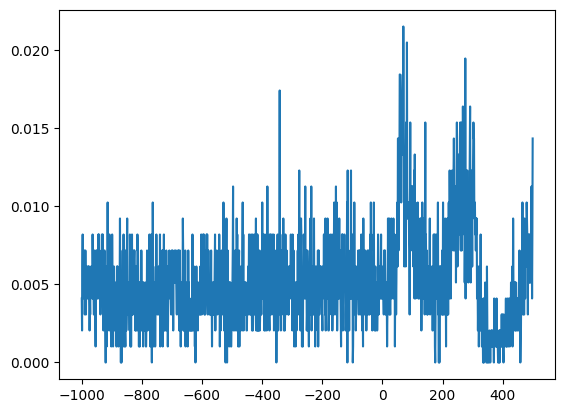

In [21]:
# solution
pop_firing_rate_LM_trial_avg = np.mean(spike_counts_LM, axis=(0,1))

plt.plot(time_from_stimulus_onset, pop_firing_rate_LM_trial_avg)

## Section 2

Make figure with subplots where firing rates and CSD plots are shown together.

| Code                                                                          | Description                                            |
| ------------------------------------------------------------------------------| ------------------------------------------------------ |
| `plt.plot(x, y)` | Plot y values against x values. |
| `plt.pcolormesh(x, y, C, cmap='RdBu_r')` | Make a 2D colormap of values in a 2D array (C) against x and y values with the colormap set with `cmap`.|
| `fig, ax = plt.subplots(nrows, ncols)` | Tells python to create a grid of subplots with `nrows` number of rows and `ncols` number of columns. `ax` can be indexed to refer to a specific subplot, f.ex. the subplot on the first row and second column would be `ax[0,1]`.|
| `gaussian_filter1d(data, sigma = filter_width)` | Apply a 1D gaussian filter that smoothes the data to reduce the prominence of noise in a plot. `sigma = filter_width` designates the width of the filter. |

In [22]:
from elephant.current_source_density import estimate_csd

Run cell below to calculate the CSD and the population firing rates.

In [23]:
# provided

lfp_neo = utils.create_neo_lfp(lfp_values=lfp_trial_avg.values.T, sampling_frequency=sampling_frequency_lfp) # The lfp must be transposed to have time on the first dimension for neo
coords = utils.add_um_units(channels_depth_vals=channels_depth.values)
csd_neo = estimate_csd(lfp_neo, coordinates=coords, method='DeltaiCSD', diam=400*pq.um).T # The csd must be transposed to get channels on first dimension for the plot

pop_firing_rate_LGN_trial_avg = np.mean(spike_counts_LGN, axis=(0,1))*1E3 # multiply with 1E3 to scale to Hz

# get sampling time points of LFP and spike data
times_lfp = lfp_trial_avg.time_from_stimulus_onset_lfp
times_spikes = spike_counts_LGN.time_from_stimulus_onset_spikes

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


**Example**: Make a figure with one subplot containing the V1 CSD and one subplot containing the trial averaged LGN firing rate from 500 ms before stimulus onset to 500 ms after stimulus onset (both the firing rate and the CSD in this time window are extracted for you if you run the cell below).

In [28]:
# provided

time_window_start = -500
time_window_end = 500

# get csd and time points of lfp samples in time window
mask_window_lfp = (times_lfp > time_window_start) & (times_lfp < time_window_end)
times_window_lfp = times_lfp[mask_window_lfp]
csd_window = csd_neo[:, mask_window_lfp]

# get population firing rate and time points of spike data samples in time window
mask_window_spikes = (times_spikes > time_window_start) & (times_spikes < time_window_end)
times_window_spikes = times_spikes[mask_window_spikes]
pop_firing_rate_LGN_window = pop_firing_rate_LGN_trial_avg[mask_window_spikes]

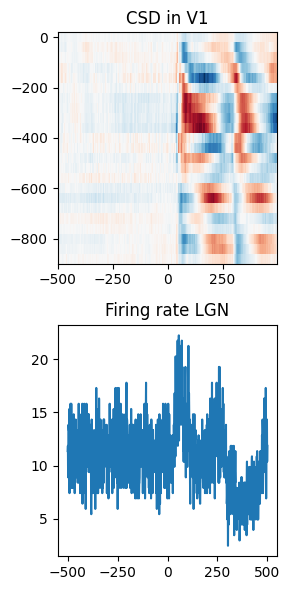

In [32]:
# solution

# Plot CSD and LGN population firing rates together with subplots

fig, ax = plt.subplots(nrows=2, figsize = (3,6))

ax[0].pcolormesh(times_window_lfp, channels_depth, csd_window, cmap = 'RdBu_r')
ax[0].set_title('CSD in V1')

ax[1].plot(times_window_spikes, pop_firing_rate_LGN_window)
ax[1].set_title('Firing rate LGN')

fig.tight_layout()

**Exercise**: Make a figure with one subplot containing the V1 CSD and one subplot containing the trial averaged LGN firing rate for the time window from 0 ms before stimulus onset to 100 ms after (both are calculated for you in the cell below).

Do you notice anything when you compare the timing of the *first* peak in the LGN firing rate and the onset of the *first* sink in the V1 CSD?

In [33]:
# provided

time_window_start = 0
time_window_end = 100

# get csd and time points of lfp samples in time window
mask_window_lfp = (times_lfp > time_window_start) & (times_lfp < time_window_end)
times_window_lfp = times_lfp[mask_window_lfp]
csd_window = csd_neo[:, mask_window_lfp]

# get population firing rate and time points of spike data samples in time window
mask_window_spikes = (times_spikes > time_window_start) & (times_spikes < time_window_end)
times_window_spikes = times_spikes[mask_window_spikes]
pop_firing_rate_LGN_window = pop_firing_rate_LGN_trial_avg[mask_window_spikes]

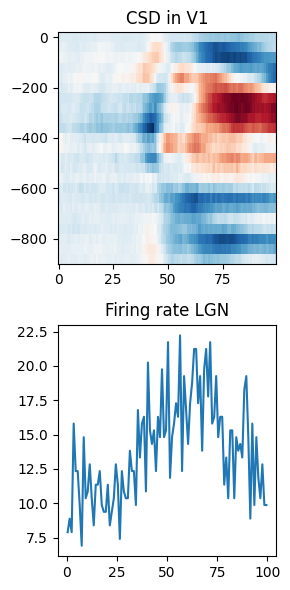

In [34]:
# solution

fig, ax = plt.subplots(nrows=2, figsize = (3,6))

ax[0].pcolormesh(times_window_lfp, channels_depth, csd_window, cmap = 'RdBu_r')
ax[0].set_title('CSD in V1')

ax[1].plot(times_window_spikes, pop_firing_rate_LGN_window)
ax[1].set_title('Firing rate LGN')

fig.tight_layout()

Due to noise, it's not always that easy to determine what's the initial peak when looking at such firing rate plots. Smoothing with filters can help reduce the noise in the plot and make the onset of peaks more visible.

**Exercise**: Apply a gaussian filter with sigma = 1 to the firing rate for LGN. Then make the same figure with subplots for the trial averaged population firing rate in LGN and  the CSD for the first 100 ms after stimulus onset.

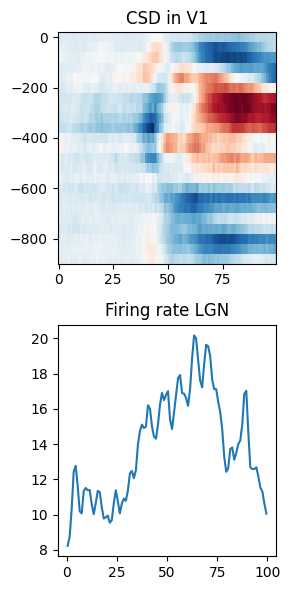

In [37]:
# solution

fig, ax = plt.subplots(nrows=2, figsize = (3,6))

ax[0].pcolormesh(times_window_lfp, channels_depth, csd_window, cmap = 'RdBu_r')
ax[0].set_title('CSD in V1')

pop_firing_rate_LGN_window_smooth = gaussian_filter1d(pop_firing_rate_LGN_window,sigma=(1))
ax[1].plot(times_window_spikes, pop_firing_rate_LGN_window_smooth)
ax[1].set_title('Firing rate LGN')

fig.tight_layout()

**Exercise**: Make a figure with the CSD of V1 for the first 100 ms after stimulus onset in one subplot and the trial-averaged firing rates of the higher visual area **LM** for the same time period in another subplot. 

Without smoothing, do you notice anything when you compare the timing of the **first** peak in the LM firing rate and the onset of the **later** sinks in the V1 CSD?

In [38]:
# provided

pop_firing_rate_LM_trial_avg = np.mean(spike_counts_LM, axis=(0,1))*1E3 # multiply with 1E3 to scale to Hz

# get population firing rate of LM in time window
pop_firing_rate_LM_window = pop_firing_rate_LM_trial_avg[mask_window_spikes]

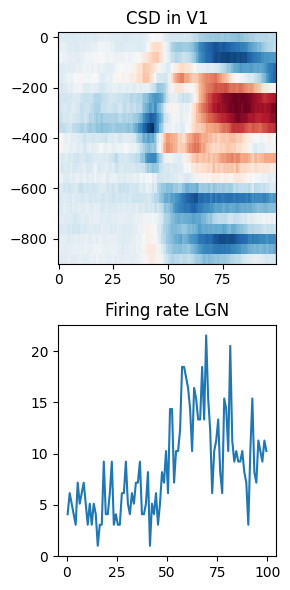

In [ ]:
# solution
fig, ax = plt.subplots(nrows=2, figsize = (3,6))

ax[0].pcolormesh(times_window_lfp, channels_depth, csd_window, cmap = 'RdBu_r')
ax[0].set_title('CSD in V1')

ax[1].plot(times_window_spikes, pop_firing_rate_LM_window)
ax[1].set_title('Firing rate LGN')

fig.tight_layout()

**Exercise**: Apply a gaussian filter with sigma = 1 to the firing rate for **LM**. Then make the same figure with subplots for the trial averaged population firing rate in LGN and  the CSD for the first 100 ms after stimulus onset.

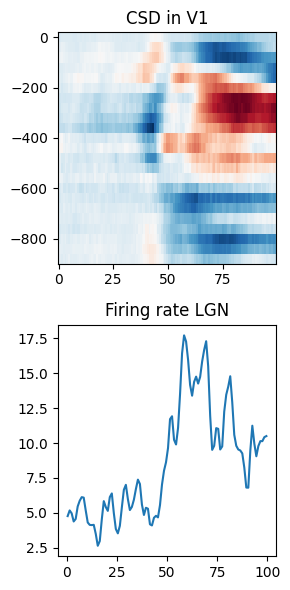

In [ ]:
# solution
fig, ax = plt.subplots(nrows=2, figsize = (3,6))

ax[0].pcolormesh(times_window_lfp, channels_depth, csd_window, cmap = 'RdBu_r')
ax[0].set_title('CSD in V1')

pop_firing_rate_LM_window_smooth = gaussian_filter1d(pop_firing_rate_LM_window,sigma=(1))
ax[1].plot(times_window_spikes, pop_firing_rate_LM_window_smooth)
ax[1].set_title('Firing rate LGN')

fig.tight_layout()

**Exercise**: Make a figure with the CSD of V1 for the first 100 ms after stimulus onset in one subplot and the trial-averaged firing rates of the **V1** for the same time period in another subplot. Apply smoothing with ``sigma = 1``.

In [41]:
# provided

pop_firing_rate_V1_trial_avg = np.mean(spike_counts_V1, axis=(0,1))*1E3 # multiply with 1E3 to scale to Hz

# get population firing rate of LM in time window
pop_firing_rate_V1_window = pop_firing_rate_V1_trial_avg[mask_window_spikes]

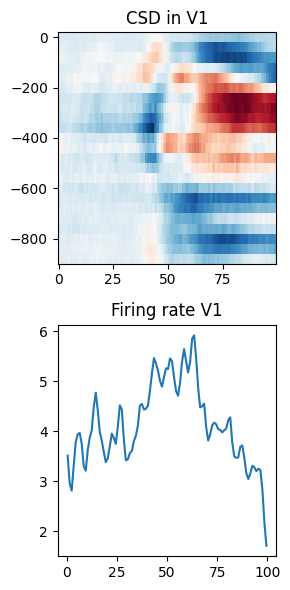

In [42]:
# solution
fig, ax = plt.subplots(nrows=2, figsize = (3,6))

ax[0].pcolormesh(times_window_lfp, channels_depth, csd_window, cmap = 'RdBu_r')
ax[0].set_title('CSD in V1')

pop_firing_rate_V1_window_smooth = gaussian_filter1d(pop_firing_rate_V1_window,sigma=(1))
ax[1].plot(times_window_spikes, pop_firing_rate_V1_window_smooth)
ax[1].set_title('Firing rate V1')

fig.tight_layout()

## Section 3



### Add axes to plots

An alternative to creating a figure with subplots is to plot the CSD and the firing rates together in the same plot. To do that, we need to add a third axis to the plot.

| Code                                                                          | Description                                            |
| ------------------------------------------------------------------------------| ------------------------------------------------------ |
| `plt.plot(x, y)` | Plot y values against x values. |
| `plt.pcolormesh(x, y, C, cmap='RdBu_r')` | Make a 2D colormap of values in a 2D array (C) against x and y values with the colormap set with `cmap`.|
| `fig, ax = plt.subplots(nrows, ncols)` | Tells python to create a grid of subplots with `nrows` number of rows and `ncols` number of columns. `ax` can be indexed to refer to a specific subplot, f.ex. the subplot on the first row and second column would be `ax[0,1]`.|
| `gaussian_filter1d(data, sigma = filter_width)` | Apply a 1D gaussian filter that smoothes the data to reduce the prominence of noise in a plot. `sigma = filter_width` designates the width of the filter. |
| `ax_twin = ax1.twinx()` | Makes an extra axis in a subplot (the subplot of ``ax1``) such that data with different units can be plotted together in the same plot.|

Run the cell below to get the CSD and the population firing rates.

In [43]:
# provided

lfp_neo = utils.create_neo_lfp(lfp_values=lfp_trial_avg.values.T, sampling_frequency=sampling_frequency_lfp) # The lfp must be transposed to have time on the first dimension for neo
coords = utils.add_um_units(channels_depth_vals=channels_depth.values)
csd_neo = estimate_csd(lfp_neo, coordinates=coords, method='DeltaiCSD', diam=400*pq.um).T # The csd must be transposed to get channels on first dimension for the plot

pop_firing_rate_V1_trial_avg = np.mean(spike_counts_V1, axis=(0,1))*1E3 # multiply with 1E3 to scale to Hz

# get sampling time points of LFP and spike data
times_lfp = lfp_trial_avg.time_from_stimulus_onset_lfp
times_spikes = spike_counts_V1.time_from_stimulus_onset_spikes

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


**Example**: Plot the firing rate of **V1** and the CSD from V1 *together in the same plot* using ``ax.twinx()``.

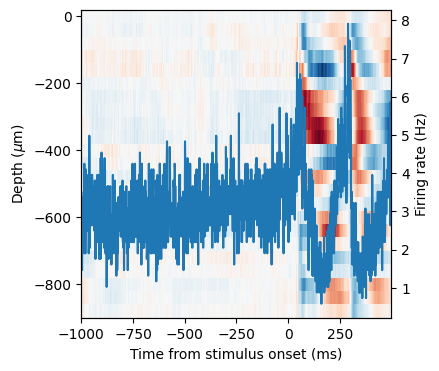

In [44]:
# solution

fig, ax = plt.subplots(nrows = 1, figsize = (4,4))

ax1 = ax
im = ax1.pcolormesh(times_lfp, channels_depth, csd_neo, cmap = 'RdBu_r')
ax1.set(xlabel='Time from stimulus onset (ms)', ylabel=r'Depth ($\mu$m)')

ax2 = ax1.twinx()
ax2.plot(times_spikes, pop_firing_rate_V1_trial_avg)
ax2.set(ylabel='Firing rate (Hz)');

**Exercise**: Plot the population firing rate of **LGN** and the CSD from V1 *together in the same plot* using ``ax.twinx()``. You can apply a gaussian filter to the firing rate if you want to reduce the noise in the plot.

In [45]:
# provided

pop_firing_rate_LGN_trial_avg = np.mean(spike_counts_LGN, axis=(0,1))*1E3 # multiply with 1E3 to scale to Hz

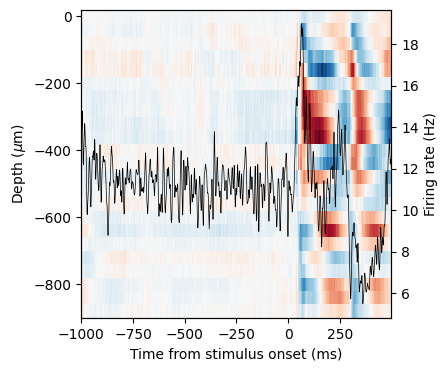

In [50]:
# solution
fig, ax = plt.subplots(nrows = 1, figsize = (4,4))

ax1 = ax
im = ax1.pcolormesh(times_lfp, channels_depth, csd_neo, cmap = 'RdBu_r')
ax1.set(xlabel='Time from stimulus onset (ms)', ylabel=r'Depth ($\mu$m)')

pop_firing_rate_LGN_trial_avg_smooth = gaussian_filter1d(pop_firing_rate_LGN_trial_avg,sigma=2)
ax2 = ax1.twinx()
ax2.plot(times_spikes, pop_firing_rate_LGN_trial_avg_smooth, color='black', linewidth=.5)
ax2.set(ylabel='Firing rate (Hz)');

**Exercise**: Plot the population firing rate of **LGN** and the CSD from V1 *for the first 100 ms after stimulus onset* using `ax.twinx()`.

In [51]:
# provided

time_window_start = 0
time_window_end = 100

# get csd and time points of lfp samples in time window
mask_window_lfp = (times_lfp > time_window_start) & (times_lfp < time_window_end)
times_window_lfp = times_lfp[mask_window_lfp]
csd_window = csd_neo[:, mask_window_lfp]

# get population firing rate and time points of spike data samples in time window
mask_window_spikes = (times_spikes > time_window_start) & (times_spikes < time_window_end)
times_window_spikes = times_spikes[mask_window_spikes]
pop_firing_rate_LGN_window = pop_firing_rate_LGN_trial_avg[mask_window_spikes]

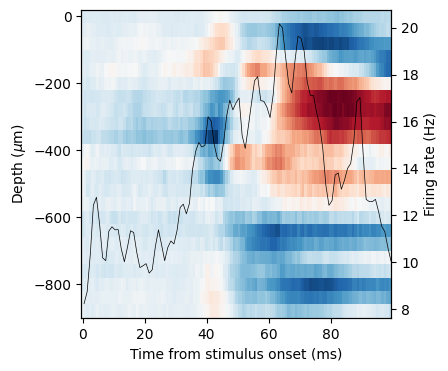

In [53]:
# solution
# solution
fig, ax = plt.subplots(nrows = 1, figsize = (4,4))

ax1 = ax
im = ax1.pcolormesh(times_window_lfp, channels_depth, csd_window, cmap = 'RdBu_r')
ax1.set(xlabel='Time from stimulus onset (ms)', ylabel=r'Depth ($\mu$m)')

pop_firing_rate_LGN_window_smooth = gaussian_filter1d(pop_firing_rate_LGN_window,sigma=1)
ax2 = ax1.twinx()
ax2.plot(times_window_spikes, pop_firing_rate_LGN_window_smooth, color='black', linewidth=.5)
ax2.set(ylabel='Firing rate (Hz)');

**Exercise**: Plot the firing rate of all three structures (LGN, V1, and LM) and the CSD from V1 *together in the same plot* using ``ax.twinx()``. Normalize the firing rates with the max value. If you want, you can smooth the firing rates with a gaussian filter.

In [54]:
# provided

pop_firing_rate_LM_trial_avg = np.mean(spike_counts_LM, axis=(0,1))*1E3 # multiply with 1E3 to scale to Hz
pop_firing_rate_LM_window = pop_firing_rate_LM_trial_avg[mask_window_spikes]

pop_firing_rate_V1_trial_avg = np.mean(spike_counts_V1, axis=(0,1))*1E3
pop_firing_rate_V1_window = pop_firing_rate_V1_trial_avg[mask_window_spikes]

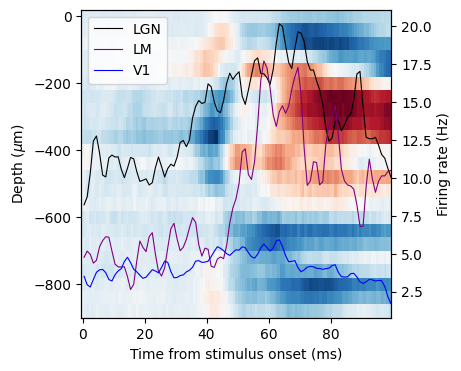

In [56]:
# solution
fig, ax = plt.subplots(nrows = 1, figsize = (4,4))

ax1 = ax
im = ax1.pcolormesh(times_window_lfp, channels_depth, csd_window, cmap = 'RdBu_r')
ax1.set(xlabel='Time from stimulus onset (ms)', ylabel=r'Depth ($\mu$m)')

pop_firing_rate_LGN_window_smooth = gaussian_filter1d(pop_firing_rate_LGN_window,sigma=1)
pop_firing_rate_LM_window_smooth = gaussian_filter1d(pop_firing_rate_LM_window,sigma=1)
pop_firing_rate_V1_window_smooth = gaussian_filter1d(pop_firing_rate_V1_window,sigma=1)

ax2 = ax1.twinx()
ax2.plot(times_window_spikes, pop_firing_rate_LGN_window_smooth, color='black', linewidth=.8, label='LGN')
ax2.plot(times_window_spikes, pop_firing_rate_LM_window_smooth, color='purple', linewidth=.8, label='LM')
ax2.plot(times_window_spikes, pop_firing_rate_V1_window_smooth, color='blue', linewidth=.8,label='V1')
ax2.set(ylabel='Firing rate (Hz)');
plt.legend()

## Section 4

### Interpolating signals with different sampling rates to quantify their association

Since the spikes and the LFP are sampled at different frequencies (here, the spikes have a sampling frequency of 1000 Hz and the LFP has a sampling frequency of 1250 Hz), we have to interpolate the signals onto the same basis to be able to calculate statistical associations between them.

| Code | Description |
| :-- | :-- |
| `f = RectBivariateSpline(x,y,z)` | Create function to use for interpolation of signal. |
| `signal_interpolated = f(x_new, y_new)` | Create the interpolated signal using the function created with the code above and the new x- and y-basis as input.|
| `correlation, p_value = scipy.stats.pearsonr(signalA, signalB)` | Calculate the pearson correlation between signal A and signal B.|

In [57]:
from scipy.interpolate import RectBivariateSpline

from scipy.stats import pearsonr

In [58]:
# provided

lfp_neo = utils.create_neo_lfp(lfp_values=lfp_trial_avg.values.T, sampling_frequency=sampling_frequency_lfp) # The lfp must be transposed to have time on the first dimension for neo
coords = utils.add_um_units(channels_depth_vals=channels_depth.values)
csd_neo = estimate_csd(lfp_neo, coordinates=coords, method='DeltaiCSD', diam=400*pq.um).T # The csd must be transposed to get channels on first dimension for the plot

pop_firing_rate_V1_trial_avg = np.mean(spike_counts_V1, axis=(0,1))*1E3 # multiply with 1E3 to scale to Hz

# get sampling time points of LFP and spike data
times_lfp = lfp_trial_avg.time_from_stimulus_onset_lfp
times_spikes = spike_counts_V1.time_from_stimulus_onset_spikes

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


**Example**: Interpolate the CSD for the first 100 ms after flash onset so that it has the same basis (sampling rate) as the firing rate in **LGN** Make a figure with subplots where you plot both the original and the interpolated CSD. The CSD should be have the same main pattern, but the ticks on the x-axis should be different.

In [ ]:
# solution

time_basis_csd = np.linspace(0., 1., csd_neo.shape[1])
channel_basis_csd = np.linspace(0., 1., csd_neo.shape[0])

interpolation_function = RectBivariateSpline(time_basis_csd, channel_basis_csd, csd_neo.T)

new_time_basis = np.linspace(0., 1., len(pop_firing_rate_LGN_trial_avg))
new_channel_basis = channel_basis_csd # only interpolate on time axis, so channel basis is unchanged

csd_interpolated = interpolation_function(new_time_basis, new_channel_basis).T

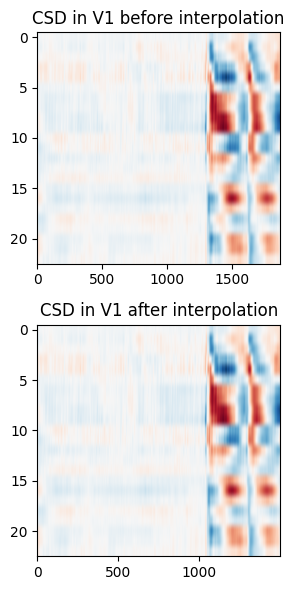

In [65]:
# do a visualization check to see that the CSD is still the same after interpolation

fig, ax = plt.subplots(nrows = 2, figsize=(3,6))
ax[0].imshow(csd_neo, cmap='RdBu_r', aspect='auto')
ax[0].set_title('CSD in V1 before interpolation')

ax[1].imshow(csd_interpolated, cmap='RdBu_r', aspect='auto')
ax[1].set_title('CSD in V1 after interpolation')

fig.tight_layout()

**Exercise**: Select the time window *from 0 to 50 milliseconds* after stimulus onset and interpolate the CSD so that the CSD and the firing rate in **LGN** have the same time basis (the same sampling rate). Plot original and interpolated CSD in this 250 ms time window in different subplots to do a visual check of the interpolation.

In [66]:
# provided

time_window_start = 0
time_window_end = 50

# get csd and time points of lfp samples in time window
mask_window_lfp = (times_lfp > time_window_start) & (times_lfp < time_window_end)
times_window_lfp = times_lfp[mask_window_lfp]
csd_window = csd_neo[:, mask_window_lfp]

# get population firing rate and time points of spike data samples in time window
mask_window_spikes = (times_spikes > time_window_start) & (times_spikes < time_window_end)
times_window_spikes = times_spikes[mask_window_spikes]
pop_firing_rate_LGN_window = pop_firing_rate_LGN_trial_avg[mask_window_spikes]

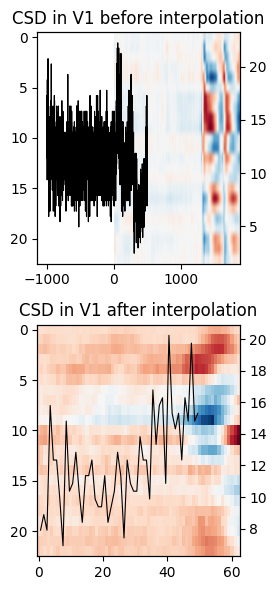

In [69]:
# solution
fig, ax = plt.subplots(nrows = 2, figsize=(3,6))
ax[0].imshow(csd_neo, cmap='RdBu_r', aspect='auto')
ax2 = ax[0].twinx()
ax2.plot(times_spikes, pop_firing_rate_LGN_trial_avg, color='black', linewidth=.8, label='LGN')
ax[0].set_title('CSD in V1 before interpolation')

ax[1].imshow(csd_window, cmap='RdBu_r', aspect='auto')
ax2 = ax[1].twinx()
ax2.plot(times_window_spikes, pop_firing_rate_LGN_window, color='black', linewidth=.8, label='LGN')
ax[1].set_title('CSD in V1 after interpolation')

fig.tight_layout()


In [45]:
# do a visualization check to see that the CSD is still the same after interpolation


When the firing rate and the CSD have the same basis (an equal number of samples in a time window), it's possible to calculate the statistical association between them.

**Exercise**: Calculate the correlation between the interpolated CSD from channel index 8 and the firing rate in LGN in the 50 ms after stimulus onset time window. (Remember that since current sinks have negative values, the sign of the correlation would be negative if a peak in the LGN firing rate and a current sink coincide in time.)

In [46]:
# solution


**Exercise**: Plot the CSD trace in channel 8 and the population firing rate in LGN together in the same plot using `ax.twinx()`.

In [47]:
# solution
